# Тема: Generative adversarial networks

1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [24]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu'
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            
            return layers

        self.model = nn.Sequential(
            # input 64x2
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        pred = self.model(z)
        return pred

In [27]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)
        
        nn.init.uniform_(self.weights, -0.5, 0.5) 
        nn.init.uniform_(self.bias, -0.5, 0.5)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)

In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, pred):
        validity = self.model(pred)

        return validity

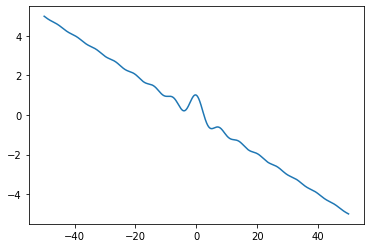

In [29]:
x = np.linspace(-50,50,10000)

def func_y(x):
    return np.sin(x)/x - x/10


plt.plot(x, func_y(x))
plt.show()

In [30]:
n_epochs = 20
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

In [31]:
x_y_data = np.array([(x_i, func_y(x_i)) for x_i in x])

real_data = torch.utils.data.DataLoader(
    x_y_data,
    batch_size=batch_size,
    shuffle=True)

generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

d_loss_history = []
g_loss_history = []

[Epoch 19/20] [Batch 142/157] [D loss: 1.297924] [G loss: 2.163582]


<Figure size 432x288 with 0 Axes>

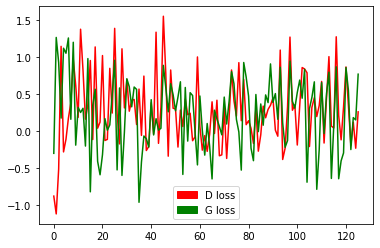

In [32]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

for epoch in range(n_epochs):
    for i, data in enumerate(real_data):
        
        cur_batch_size = len(data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_ex = Variable(data.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума (нормальное распределение тут не подойдёт)
        z = Variable(torch.FloatTensor(np.random.uniform(-50, 50, (cur_batch_size, latent_dim)))).to(device)

        gen_ex = generator(z)

        validity = discriminator(gen_ex)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_ex)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_ex.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()


In [33]:
generator.eval()

test_z = Variable(torch.from_numpy(np.random.uniform(-50, 50, (64, latent_dim)).astype(np.float64)).float()).to(device)

with torch.no_grad():
    test_pred = generator(test_z)

In [35]:
cnt = 0
error = 0.0
count = 0
for i in range(len(test_pred)):
    x = test_pred[i][0]
    y_real = func_y(x)  
    y_pred = test_pred[i][1]  
    count +=1
    error += abs(y_real - y_pred)

print("\nTotal mean error: %.10f" % (error/count))


Total mean error: 0.1264459193


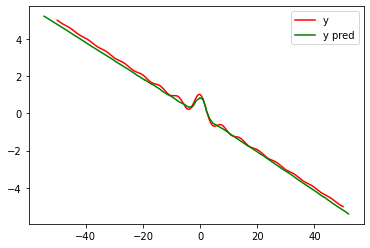

In [37]:
plt.figure()

x = np.linspace(-50, 50, 1000)
plt.plot(x, func_y(x), label='y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')


plt.legend()
plt.show()